# 05.3 - ADAM Optimiser

In this section we briefly explore the ADAM optimiser, [original paper](https://arxiv.org/pdf/1412.6980.pdf)[1] published first in 2014 by Kingma and Lei Ba. This is an adaptive optimiser and although we did not explore the theory behind it very closely, this is an adaptive optimiser that gives smaller weights to parameters that had large updates in the previous step and vice versa for the next update. 

From our understanding, ADAM should converge more reliably to some 'true' minimum for a large variety of different types of gradients. As a result, its final performance is likely to be of more importance than its rate of convergence, though the latter may still be superior, but we touch on this later.

In [1]:
import time
import json

import random as python_random
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Input
from keras.layers import Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.metrics import TruePositives
from tensorflow.keras.metrics import KLDivergence

from mlxtend.plotting import plot_confusion_matrix

#for reproducibility, we set random seeds here
#Jupyter can sometimes assign seed value only in the cell that the random seed is called
#you can change this rseed value so the entire notebook changes seed values
rseed = 42

np.random.seed(rseed)
python_random.seed(rseed)
tf.random.set_seed(rseed)

#### Load Data

In [2]:
#load the dataframes created in the Data.ipynb section
X_train = pd.read_csv('..\data\X_train.csv')
X_val = pd.read_csv('..\data\X_val.csv')
X_test = pd.read_csv('..\data\X_test.csv')

y_train_bin = pd.read_csv('..\data\y_train_bin.csv')
y_val_bin = pd.read_csv('..\data\y_val_bin.csv')
y_test_bin = pd.read_csv('..\data\y_test_bin.csv')

y_train_multi = pd.read_csv('..\data\y_train_multi.csv')
y_val_multi = pd.read_csv('..\data\y_val_multi.csv')
y_test_multi = pd.read_csv('..\data\y_test_multi.csv')

In [3]:
#turn string labels into float categories, categs is list of categories
y_train_multi, categs = pd.factorize(y_train_multi.connection_category)
y_val_multi, categs = pd.factorize(y_val_multi.connection_category)
y_test_multi, categs = pd.factorize(y_test_multi.connection_category)
#turn float categories into tf.keras matrix categories of dimension length(categs)
#e.g. 'normal' = [1,0,0,0,0]
y_train_multi = to_categorical(y_train_multi, num_classes = len(categs))
y_val_multi = to_categorical(y_val_multi, num_classes = len(categs))
y_test_multi = to_categorical(y_test_multi, num_classes = len(categs))

## Training

In [4]:
def binaryDNN(train_df = X_train, hidden_nodes = [10,10,10], op = 'adam', metrics = [tf.keras.metrics.AUC()]):
    '''
    Function that takes dataframe train_df and creates a binary classifer neural network 
    with single node sigmoid output
    
    train_df = dataframe or array 
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final output
                   layer with a single node.
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    nn_model = Sequential()
    #input dimensions
    nn_model.add(Input(shape = (train_df.shape[1],)))
    
    #add layers 
    for i in hidden_nodes:
        #we use 'relu' as good, safe default for our neural nets
        nn_model.add(Dense(i, activation = 'relu'))
        
    #output layer
    nn_model.add(Dense(1, activation = 'sigmoid'))
    
    #compile model
    nn_model.compile(loss='binary_crossentropy',optimizer=op,metrics=metrics)
    
    return nn_model

 

def multiDNN(train_df = X_train, num_classes = 5, hidden_nodes = [10,10,10], op = 'adam', 
             c_metrics = ['accuracy',TruePositives(),tfa.metrics.CohenKappa(num_classes=5)]):
    
    '''
    Function that takes dataframe train_df and creates a multiclass classifer neural network 
    with softmax output layers equal to the number of classes passed
    
    train_df = dataframe or array 
    num_classes = int, number of classes in the dataset
    hidden_nodes = list of nodes in each layer e.g. [10,10] will create a neural network
                   with input layers equal to the number of input variables, a first hidden layer
                   with 10 nodes, and a second hidden layer with 10 nodes, with a final 
                   output layer containing num_classes softmax nodes
    op = string name of optimizer e.g. 'adam', or tf.keras.optimizers instance.
    c_metrics = list of metrics to be evaluated by the model, can be string, function, or tf.keras.metrics.Metric instance
    '''
    
    #we initiate our model differently here, taking layers as a list
    #this is because of some issues when implementing when creating a neural net as above
    layers = []
    #input dimensions
    layers.append(Input(shape = (train_df.shape[1],)))
    
    #add layers with dropout
    for i in hidden_nodes:
        layers.append(Dense(i, activation = 'relu'))
        layers.append(Dropout(0.2))
        
    #output layer with number of nodes = num_classes
    layers.append(Dense(num_classes, activation = 'softmax'))
    
    nn_model = Sequential(layers)
    #compile model
    nn_model.compile(loss='categorical_crossentropy',optimizer=op,metrics=c_metrics)
    
    return nn_model

In [11]:
x1 = -np.arange(1,5)
epsilons = np.float_power(10,x1)

In [12]:
epsilons

array([0.1   , 0.01  , 0.001 , 0.0001])

Train binary and multiclass models for SGD, SGD, and SGD.

In [7]:
#Jupyter works a bit differently from a normal IDE 
#so we have to set random seed again in this cell
tf.random.set_seed(rseed)

#verbose variable
v = 0

count = 1
#number of times our model parses through the entire data it is given
epochs = 30
#number of data points the model goes through before updating next weight
batch_size = 500
start = time.time()

for eps in epsilons:
    #assign optimiser. Some are commented out and then used in other notebooks
    # sgd_mom_opt = tf.keras.optimizers.SGD(learning_rate = eps,
    #                                       momentum = 0.9,
    #                                       nesterov = False)

    # nag_opt = tf.keras.optimizers.SGD(learning_rate = eps, 
    #                                   momentum = 0.9, 
    #                                   nesterov = True)
    
    
    adam_opt = tf.keras.optimizers.Adam(learning_rate = eps)

    #this originally fit same model architecture for each optimizer ['sgd','nag','adam']
    #the list iteration format was kept because iterating over 1 variable does change runtime, realistically
    #we also wanted to demonstrate the code style were we to not face memory issues
    for opt in ['adam']:
        #assign optimizer as above
        optimizer = locals()['{}_opt'.format(opt)] 
        
        #compile model with appropriate optimizer
        bin_model_temp = binaryDNN(op = optimizer)
        #nicer preview/output readability
        print('-'*10 + 'Fitting binary model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        #record model history fitting to binary training data with validation split
        bin_history_temp = bin_model_temp.fit(X_train, y_train_bin,
                                              shuffle = True, validation_data = (X_val, y_val_bin),
                                              epochs = epochs, batch_size = batch_size,
                                              verbose = v)
        
        #assign models and their history to appropriately named variable in locals()
        locals()['{}_bin_model_{}'.format(opt,count)] = bin_model_temp
        locals()['{}_bin_history_{}'.format(opt,count)] = bin_history_temp
    
    
    
        #same as before but for multiclass categ
        categ_model_temp = multiDNN(op = optimizer)
        #nice print
        print('-'*10 + 'Fitting categorical model to {} optimizer with learning rate {}'.format(opt,eps) + '-'*10)
        #fit model
        categ_history_temp = categ_model_temp.fit(X_train, y_train_multi,
                                                  shuffle = True, validation_data = (X_val, y_val_multi),
                                                  epochs = epochs, batch_size = batch_size,
                                                  verbose = v)
        #assign model and history to variables
        locals()['{}_categ_model_{}'.format(opt,count)] = categ_model_temp
        locals()['{}_categ_history_{}'.format(opt,count)] = categ_history_temp
         
    #delete temp model and history to free up memory
    del bin_model_temp
    del bin_history_temp
    del categ_model_temp
    del categ_history_temp
    print()
        
    #increase count for iteration on next epsilon value
    count += 1
    
end = time.time()

----------Fitting binary model to adam optimizer with learning rate 0.1----------
----------Fitting categorical model to adam optimizer with learning rate 0.1----------

----------Fitting binary model to adam optimizer with learning rate 0.01----------
----------Fitting categorical model to adam optimizer with learning rate 0.01----------

----------Fitting binary model to adam optimizer with learning rate 0.001----------
----------Fitting categorical model to adam optimizer with learning rate 0.001----------

----------Fitting binary model to adam optimizer with learning rate 0.0001----------
----------Fitting categorical model to adam optimizer with learning rate 0.0001----------



In [8]:
print('Time taken to run all models:  {:2f} seconds'.format(end-start))

Time taken to run all models:  956.877773 seconds


### Save Models and Histories

We save the models and the histories created so that they can be reloaded easily if we need to do further analysis or revisit anything at a later point without running all the models again. 

Run these anyway even if you do not intend to stop and return to them, as this affects how the model histories are called later.

In [9]:
#create a folder called saved_models and one called saved_hists to prevent saving errors
!mkdir saved_models saved_hists

#since epsilons[0] corresponds to model_1 and epsilons[3] correponds to model_4 we use range(1, len(epsilons) + 1)
for i in range(1,len(epsilons)+1):
    
    #assign name to variable for better code readability later
    bin_name = '{}_bin_model_{}'.format(opt,i)
    categ_name = '{}_categ_model_{}'.format(opt,i)
    #save the binary and category models in saved_models folder
    locals()[bin_name].save('saved_models/{}'.format(bin_name))
    locals()[categ_name].save('saved_models/{}'.format(categ_name))

    #as above, for histories
    bin_hist = '{}_bin_history_{}'.format(opt,i)
    categ_hist = '{}_categ_history_{}'.format(opt,i)
    #call .history and dump using json
    json.dump(locals()[bin_hist].history, open('saved_hists/{}'.format(bin_hist), 'w'))
    json.dump(locals()[categ_hist].history, open('saved_hists/{}'.format(categ_hist), 'w'))    

A subdirectory or file saved_models already exists.
Error occurred while processing: saved_models.
A subdirectory or file saved_hists already exists.
Error occurred while processing: saved_hists.


INFO:tensorflow:Assets written to: saved_models/adam_bin_model_1\assets
INFO:tensorflow:Assets written to: saved_models/adam_categ_model_1\assets
INFO:tensorflow:Assets written to: saved_models/adam_bin_model_2\assets
INFO:tensorflow:Assets written to: saved_models/adam_categ_model_2\assets
INFO:tensorflow:Assets written to: saved_models/adam_bin_model_3\assets
INFO:tensorflow:Assets written to: saved_models/adam_categ_model_3\assets
INFO:tensorflow:Assets written to: saved_models/adam_bin_model_4\assets
INFO:tensorflow:Assets written to: saved_models/adam_categ_model_4\assets


## Load Models and Histories

Now to load the data that we just saved.

In [4]:
#change this opt varfor each optimiser later
opt = 'adam'
#reassign same epsilons in case you do not want to run from above
x1 = -np.arange(1,5)
epsilons = np.float_power(10,x1)

#load as with the saving above
for i in range(1,len(epsilons)+1):
    bin_name = '{}_bin_model_{}'.format(opt,i)
    categ_name = '{}_categ_model_{}'.format(opt,i)
    
    locals()[bin_name] = tf.keras.models.load_model('saved_models/{}'.format(bin_name))
    locals()[categ_name] = tf.keras.models.load_model('saved_models/{}'.format(categ_name))
    
    bin_hist = '{}_bin_history_{}'.format(opt,i)
    categ_hist = '{}_categ_history_{}'.format(opt,i)
    
    locals()[bin_hist] = json.load(open('saved_hists/{}'.format(bin_hist), 'r'))
    locals()[categ_hist] = json.load(open('saved_hists/{}'.format(categ_hist), 'r'))

In [5]:
#load for nag
opt2 = 'nag'

#load as with the saving above
for i in range(1,len(epsilons)+1):
    bin_name = '{}_bin_model_{}'.format(opt2,i)
    categ_name = '{}_categ_model_{}'.format(opt2,i)
    
    locals()[bin_name] = tf.keras.models.load_model('saved_models/{}'.format(bin_name))
    locals()[categ_name] = tf.keras.models.load_model('saved_models/{}'.format(categ_name))
    
    bin_hist = '{}_bin_history_{}'.format(opt2,i)
    categ_hist = '{}_categ_history_{}'.format(opt2,i)
    
    locals()[bin_hist] = json.load(open('saved_hists/{}'.format(bin_hist), 'r'))
    locals()[categ_hist] = json.load(open('saved_hists/{}'.format(categ_hist), 'r'))

## Plots and Assessing Performance

### Binary Model

**Binary Cross Entropy Loss:**<br>
We examine how ADAM behaves for the binary case and how it converges in loss. We will briefly compare to NAG.

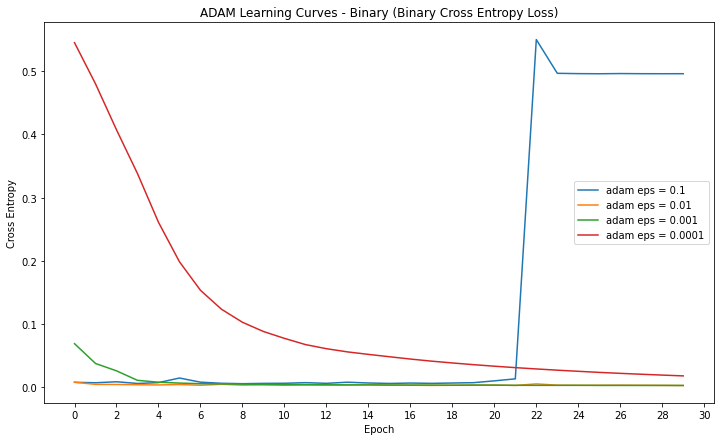

In [15]:
fig = plt.figure(figsize=(12,7))

plt.title('ADAM Learning Curves - Binary (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('Cross Entropy')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)]['val_loss'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

That was unexpected. For some reason, a learning rate of 0.1 seems to give unexpected results after a certain point. Again, in an ideal scenario we use a stopping epoch prior to this (if it were the best model) but we have better performance at other learning rates (seen below) so this is, to some extent, immaterial.

However, this behaviour is completely unexpected and we are not entirely sure why it happens. We explore this alongside training loss.

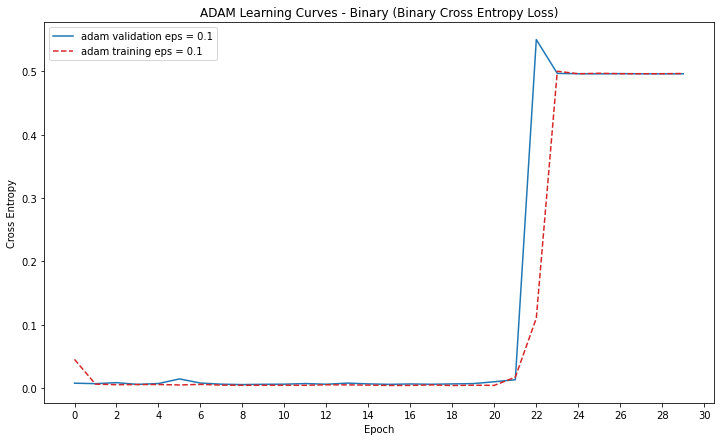

In [16]:
fig = plt.figure(figsize=(12,7))

plt.title('ADAM Learning Curves - Binary (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('Cross Entropy')

for count in [1]:
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)]['val_loss'],
             color='C0',label='{} validation eps = {}'.format(opt, epsilons[count-1]))
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)]['loss'],
             color='C3',ls='--',label='{} training eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

The same type of behaviour seems to happen with the training data. The reason for this is not clear to us.

We will explore it further with AUC. For now, we look at performance for the first 20 epochs, prior to this behaviour.

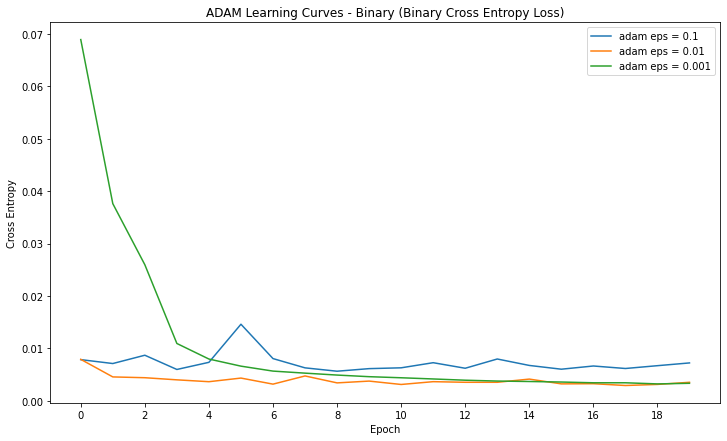

In [17]:
fig = plt.figure(figsize=(12,7))

plt.title('ADAM Learning Curves - Binary (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('Cross Entropy')

for count in range(1,len(epsilons)):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)]['val_loss'][:20],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

It seems that a learning rate of 0.01 is best for the ADAM optimiser given our setting. Questions about what an ideal stopping epoch would be is still unclear, especially as we are not certain whether ADAM is expected to go up and down in loss as NAG is, though it would not be surprising for it do so, given that it is adaptive in nature.

We briefly compared with NAG.

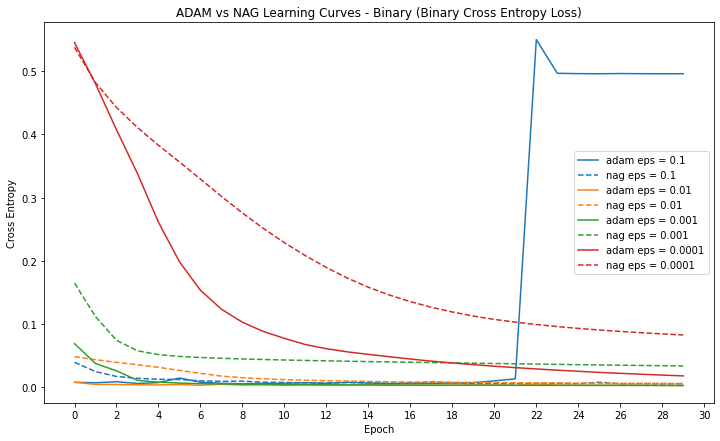

In [18]:
fig = plt.figure(figsize=(12,7))

plt.title('ADAM vs NAG Learning Curves - Binary (Binary Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('Cross Entropy')

clrs = ['C0','C1','C2','C3']

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)]['val_loss'],
             color = clrs[count-1], label='{} eps = {}'.format(opt, epsilons[count-1]))
    plt.plot(locals()['{}_bin_history_{}'.format(opt2,count)]['val_loss'],
             color = clrs[count-1], ls = '--', label='{} eps = {}'.format(opt2, epsilons[count-1]))

plt.legend()
plt.show()

ADAM does seem to converge more quickly than NAG across all learning rates, with the exception of the strange behaviour for the learning rate of 0.1 after epoch 20.

**AUC:**<br>
Briefly moving on to explore AUC

In [7]:
auc = list(adam_bin_history_1.keys())[-1]
nag_auc = list(nag_bin_history_1.keys())[-1]
auc,nag_auc

('val_auc', 'val_auc_1')

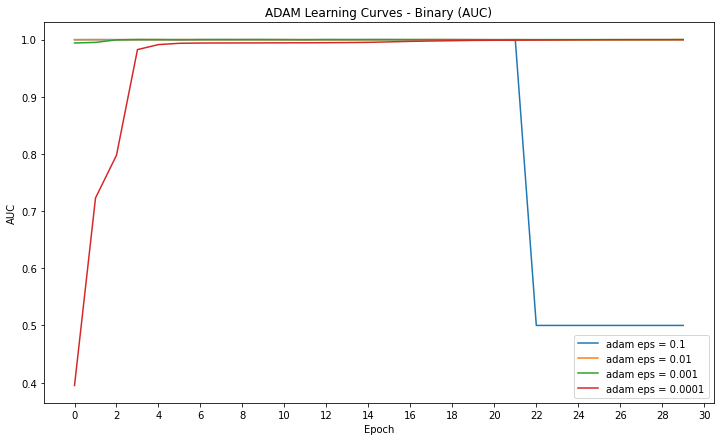

In [8]:
fig = plt.figure(figsize=(12,7))

plt.title('ADAM Learning Curves - Binary (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('AUC')


for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)][auc],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

We see the same sharp and sudden behaviour once more, but now it is more clear: it seems that after a certain point, ADAM does no better than guessing attack vs normal at random. This is a highly dramatic shift from the strong performance that it begins with, and a typical overfitting behaviour would be for it to predict only one class/category over  time, this is likely what's happening here, but this happens in a single epoch which is highly unusual.

Less interestingly, we look at the top performers for completeness

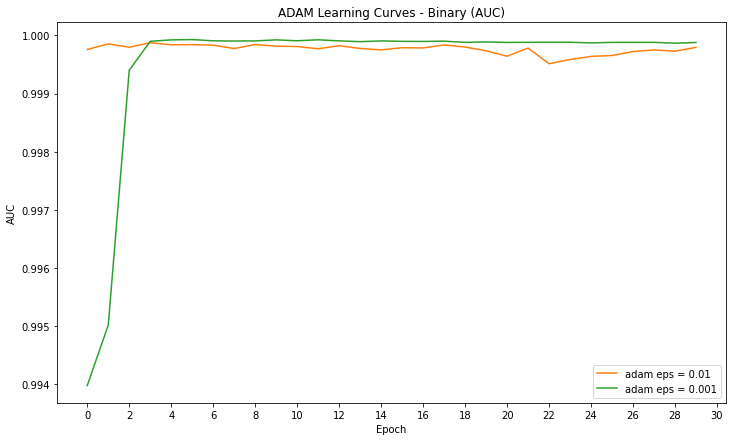

In [9]:
fig = plt.figure(figsize=(12,7))

plt.title('ADAM Learning Curves - Binary (AUC)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('AUC')

#colors set to be the same as above for consistency
clrs = ['C0','C1','C2','C3']

for count in range(2,len(epsilons)):
    plt.plot(locals()['{}_bin_history_{}'.format(opt,count)][auc],
             color=clrs[count-1],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

Learning rate of 0.01 seems to be better to begin with but drops off ever so slightly after 3 epochs, though it seems to be converging near our final epoch. A clear better performer is hard to define.

We do not perform more comparisons with NAG for now.

**Confusion Matrix**<br>
We take a look at learning rates of 0.1 and 0.01 to see what is happening.

In [10]:
tf.random.set_seed(rseed)
adam_pred = adam_bin_model_1.predict(X_test)

In [11]:
adam_pred_bin = adam_pred
adam_pred_bin[adam_pred_bin>0.5]=1
adam_pred_bin[adam_pred_bin<0.5]=0

Text(0.5, 1.0, 'Confusion Matrix for ADAM with learning rate 0.1')

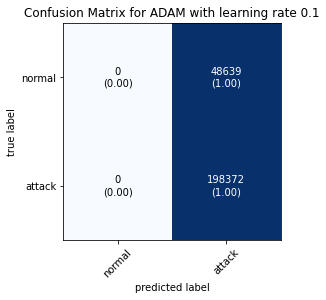

In [12]:
cmat_adam = confusion_matrix(y_test_bin,adam_pred)
cmat_adam

plot_confusion_matrix(
    conf_mat = cmat_adam,
    show_normed = True,
    class_names = ['normal','attack']
)

plt.title('Confusion Matrix for ADAM with learning rate {}'.format(epsilons[0]))

It looks like the model does regress to only predicting attacks (the more prevalent connection type). Again, we are unsure why this happens and particularly why it happens so suddenly over one or two epochs.

We look at the model with learning rate 0.001 for completeness.

In [25]:
tf.random.set_seed(rseed)
adam_pred = adam_bin_model_3.predict(X_test)

In [26]:
adam_pred_bin = adam_pred
adam_pred_bin[adam_pred_bin>0.5]=1
adam_pred_bin[adam_pred_bin<0.5]=0

Text(0.5, 1.0, 'Confusion Matrix for ADAM with learning rate 0.1')

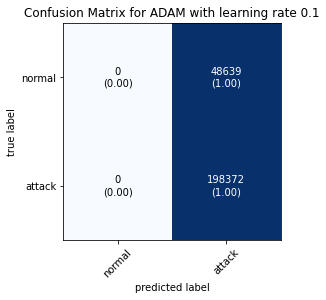

In [13]:
cmat_adam = confusion_matrix(y_test_bin,adam_pred)
cmat_adam

plot_confusion_matrix(
    conf_mat = cmat_adam,
    show_normed = True,
    class_names = ['normal','attack']
)

plt.title('Confusion Matrix for ADAM with learning rate {}'.format(epsilons[0]))

Practically perfect results as expected.

## Categorical Model

We now look at the categorical case and see if we end up with the same overfitting scenario as before, and whether this happens in the same sudden manner or around the same number of epochs.

**Categorical Cross Entropy Loss:**<br>
We start by looking at the loss alongside NAG

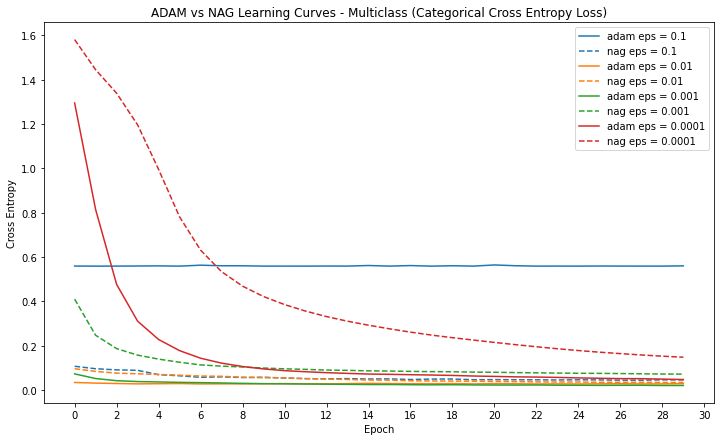

In [28]:
fig = plt.figure(figsize=(12,7))

plt.title('ADAM vs NAG Learning Curves - Multiclass (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,52,2))
plt.ylabel('Cross Entropy')

clrs = ['C0','C1','C2','C3']

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_loss'],
             color = clrs[count-1], label='{} eps = {}'.format(opt, epsilons[count-1]))
    plt.plot(locals()['{}_categ_history_{}'.format(opt2,count)]['val_loss'],
             color = clrs[count-1], ls = '--', label='{} eps = {}'.format(opt2, epsilons[count-1]))

plt.legend()
plt.show()

Again, ADAM seems to converge faster at each respective learning rate with the exception of 0.1. This time, interestingly, ADAM immediately starts off at a certain minimum it seems and stay there when the learning rate is set to 0.1. We are unsure as to why this happens and did not explore further due to time restraints.

Comparing best ADAM  learning rates for completeness

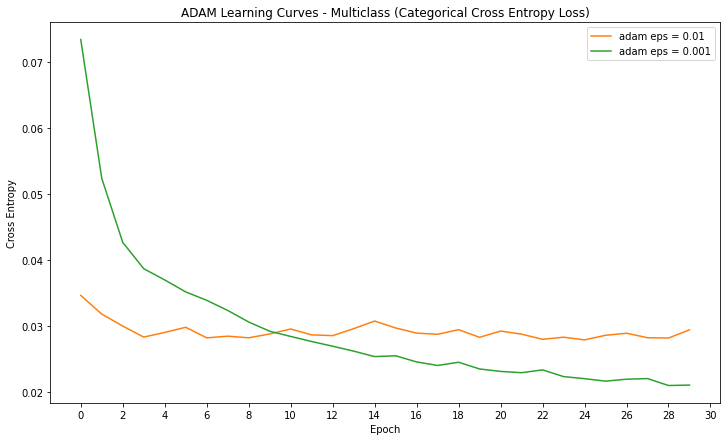

In [29]:
fig = plt.figure(figsize=(12,7))

plt.title('ADAM Learning Curves - Multiclass (Categorical Cross Entropy Loss)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cross Entropy')

for count in range(2,len(epsilons)):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_loss'],
             color=clrs[count-1],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

It seems that we have a best performer for a learing rate of 0.01 here, at least for loss.

**Categorical Accuracy:**<br>
We now take a look at categorical accuracy

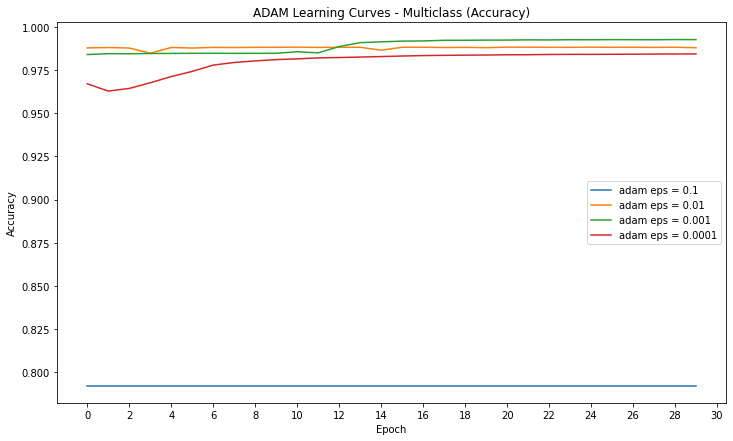

In [14]:
fig = plt.figure(figsize=(12,7))

plt.title('ADAM Learning Curves - Multiclass (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Accuracy')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_accuracy'],
             label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

The same behaviour seems to persist. The model with learning rate of 0.1 is predicting only dos attacks from what can be seen here since 'dos' connections make up 79% of the data and the accuracy score is roughly 0.79.

We examine the other learning rates for better comparison

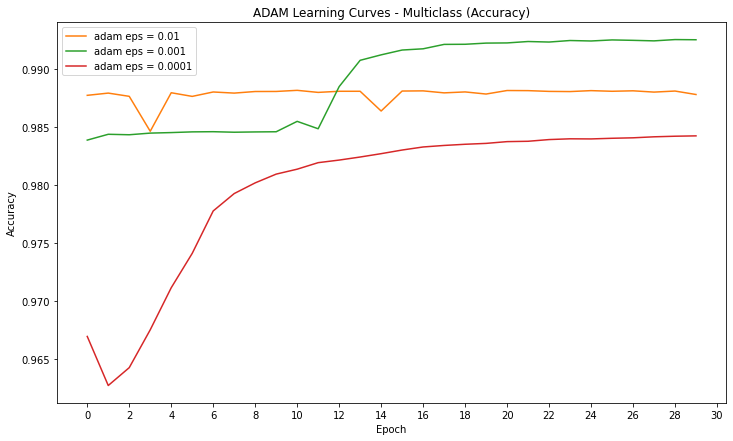

In [15]:
fig = plt.figure(figsize=(12,7))

plt.title('ADAM Learning Curves - Multiclass (Accuracy)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Accuracy')

for count in range(2,len(epsilons)+1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_accuracy'],
             color=clrs[count-1],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

It seems that we have a best performer here for a learning rate of 0.001 by a difference of roughly 1%. This is not too large but it's also not insignifcant in many scenarios.

**Cohen-Kappa**<br>
We now look at Cohen-Kappa scores and see if we have any difference (particularly in best performers)

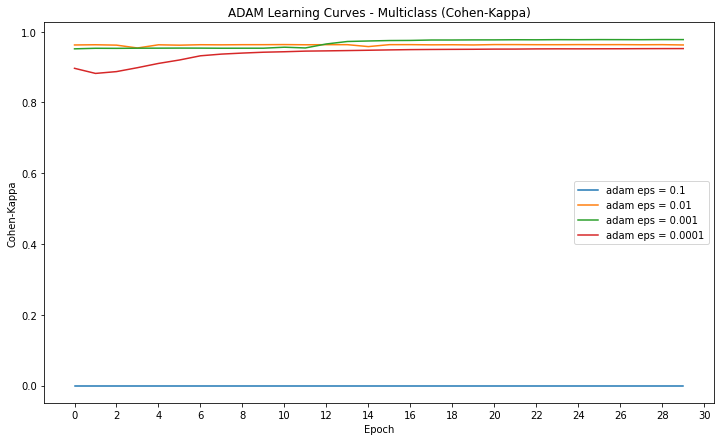

In [32]:
fig = plt.figure(figsize=(12,7))

plt.title('ADAM Learning Curves - Multiclass (Cohen-Kappa)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cohen-Kappa')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_cohen_kappa'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

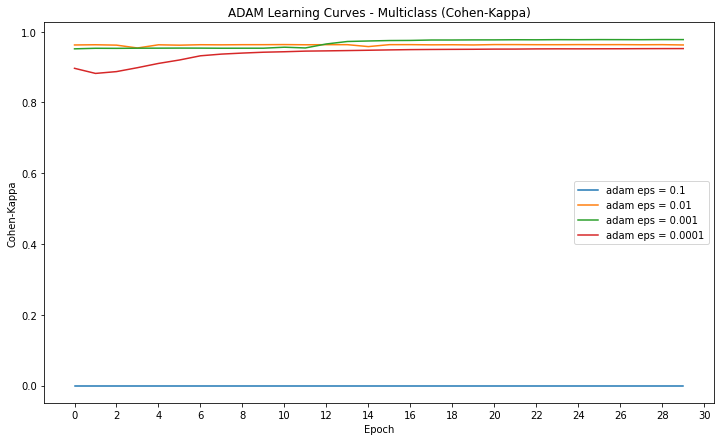

In [33]:
fig = plt.figure(figsize=(12,7))

plt.title('ADAM Learning Curves - Multiclass (Cohen-Kappa)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cohen-Kappa')

for count in range(1,len(epsilons)+1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_cohen_kappa'],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

The same graph is seen as for accuracy roughly speaking.

We take a closer look at the top 3 learning rates.

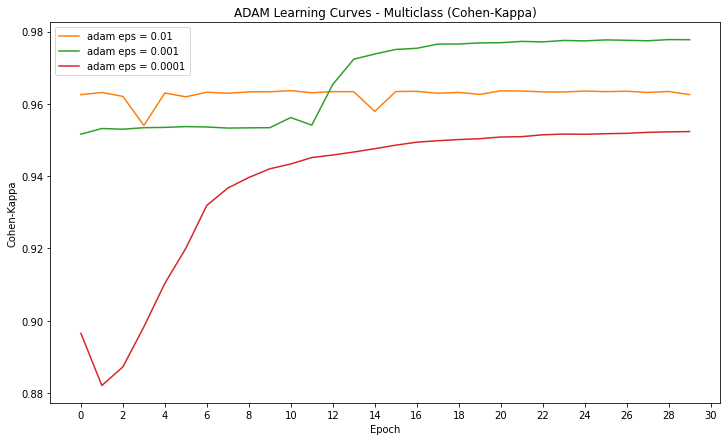

In [34]:
fig = plt.figure(figsize=(12,7))

plt.title('ADAM Learning Curves - Multiclass (Cohen-Kappa)')
plt.xlabel('Epoch')
plt.xticks(ticks=range(0,32,2))
plt.ylabel('Cohen-Kappa')

for count in range(2,len(epsilons)+1):
    plt.plot(locals()['{}_categ_history_{}'.format(opt,count)]['val_cohen_kappa'],
             color = clrs[count-1],label='{} eps = {}'.format(opt, epsilons[count-1]))

plt.legend()
plt.show()

Again, we have a best performer for a learning rate of 0.001.

**Confusion Matrices**<br>
We now explore the confusion matrices so we can more clearly see what our model is classifying the connections as.

In [35]:
tf.random.set_seed(rseed)

for i in range(len(epsilons)):
    
    model = locals()['adam_categ_model_{}'.format(i+1)]
    adam_categ_pred = model.predict(X_test)
    locals()['adam_categ_pred_{}'.format(i+1)] = adam_categ_pred

In [36]:
categs

Index(['dos', 'normal', 'probe', 'r2l', 'u2r'], dtype='object')

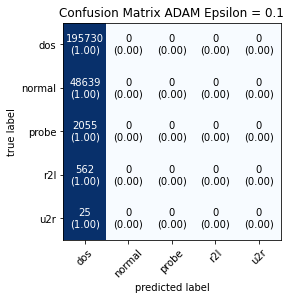

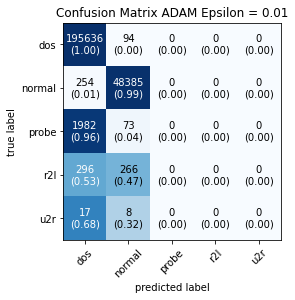

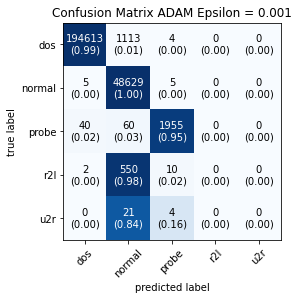

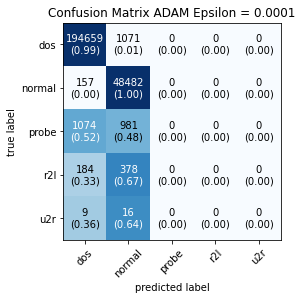

In [37]:
for i in range(len(epsilons)):
    adam_categ_pred = locals()['adam_categ_pred_{}'.format(i+1)]
    
    cmat_categ_adam = confusion_matrix(tf.argmax(y_test_multi,axis=1), tf.argmax(adam_categ_pred,axis=1))
    
    locals()['cmat_categ_adam_{}'.format(i)] = cmat_categ_adam
   
    
    plot_confusion_matrix(
        conf_mat = cmat_categ_adam,
        show_normed = True,
        class_names = categs
    )
    plt.title('Confusion Matrix {} Epsilon = {}'.format(opt.upper(),epsilons[i]))
    
del adam_categ_pred

We were correct in deducing that for a learning rate of 0.1 the model was indeed predicting all connections to be 'dos' connections. The confusion matrices also further confirm that a learning rate of 0.001 performed best, as we can see by its ability to pick up 'probe' attacks.

Overall, we find some strange results here. Namely, we thought that ADAM perform better than NAG (and it did to some extent) but a learning rate of 0.1 seemed to be particularly bad for ADAM. This does raise the question of should we be comparing the best setting for each model? In other words, should we find the best batch size, number of epochs, learning rates, among other parameters, for each model individually and compare those? We can clearly tell if we arbitrarily chose a learning rate of 0.1 for all models, then ADAM would appear to be the worst performing optimiser, so a range of parameters is useful to allow for comparison, but we believe that our setup was useful in that we are making less fitted decisions and in doing so we are being a bit more agnostic to the dataset. Concretely, the best ADAM performer for this dataset might not be the best ADAM performer for another dataset, and thus we would have less generalisation ability.

We end this section by saying that we saw an expected better performance in NAG over SGD with no momentum. We also saw that NAG and SGD with momentum are almost certainly the exact same (at least for this dataset) and so that raises questions about the TensorFlow documentation, which we pointed out in the 01 - Introduction section of this report, though we have not explored whether this generalises for other datasets or not as that is not part of the scope of this work. Further, we expected ADAM to perform better than NAG overall, and it seemingly did so for different learning rates but behaved very oddly for a learning rate of 0.1.

In the next section, we take a quick look at the best performing models from each optimiser.

## References for Section 5.3

- [1] Kingma, Lei Ba 2014 https://arxiv.org/pdf/1412.6980.pdf ICLR 2015 paper